In [6]:
import pandas as pd

# import data

data_df = pd.read_csv("restaurants_norm_reduced_discretized_infogain.csv")
data_df.head()

,longitude,state,latitude,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,...,sunday,thursday,touristy,trendy,tuesday,upscale,valet,validated,wednesday,Popularity
0,(-92.572163--69.498949],ON,(42.874072-45.308688],11:0-3:0,11:0-2:0,11:0-3:0,11:0-2:0,11:0-3:0,11:0-2:0,11:0-2:0,...,Missing,Missing,FALSE,FALSE,Missing,FALSE,FALSE,FALSE,Missing,(-inf-0.1]
1,(-inf--92.572163],AZ,(-inf-35.570226],10:0-22:0,10:0-22:0,10:0-22:0,10:0-22:0,10:0-22:0,10:0-22:0,10:0-22:0,...,Missing,Missing,FALSE,FALSE,Missing,FALSE,FALSE,FALSE,Missing,(-inf-0.1]
2,(-inf--92.572163],NV,(35.570226-38.004841],11:0-21:30,11:0-21:30,11:0-21:30,11:30-21:0,11:0-21:30,11:0-21:30,11:0-21:30,...,Missing,Missing,FALSE,FALSE,Missing,FALSE,FALSE,FALSE,Missing,(-inf-0.1]
3,(-92.572163--69.498949],QC,(45.308688-47.743303],6:30-17:0,6:30-17:0,N,N,6:30-17:0,6:30-17:0,6:30-17:0,...,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,(-inf-0.1]
4,(-92.572163--69.498949],ON,(42.874072-45.308688],10:45-22:0,10:45-22:0,10:45-22:0,10:45-22:0,10:45-22:0,10:45-22:0,10:45-22:0,...,Missing,Missing,FALSE,FALSE,Missing,FALSE,FALSE,FALSE,Missing,(-inf-0.1]


In [7]:
# encode categorical variables into ints

from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

encoder_dict = defaultdict(LabelEncoder)

data_encoded_df = data_df.apply(lambda x: encoder_dict[x.name].fit_transform(x))
data_encoded_df.head()

,longitude,state,latitude,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,...,sunday,thursday,touristy,trendy,tuesday,upscale,valet,validated,wednesday,Popularity
0,2,15,4,132,126,141,134,132,127,129,...,1,1,0,0,1,0,2,0,1,0
1,3,0,0,30,33,41,46,31,32,32,...,1,1,0,0,1,0,2,0,1,0
2,3,12,1,119,118,128,166,120,118,120,...,1,1,0,0,1,0,2,0,1,0
3,2,17,5,618,561,868,788,589,574,576,...,1,1,1,1,1,1,3,1,1,0
4,2,15,4,84,83,92,93,84,84,83,...,1,1,0,0,1,0,2,0,1,0


In [9]:
# Split variables and target

from sklearn.preprocessing import label_binarize

X = data_encoded_df.ix[:, range(0, 55)].values
Y = data_encoded_df.ix[:, 55].values

# transform the target into one-hot encoding
y = label_binarize(Y, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y.shape[1]

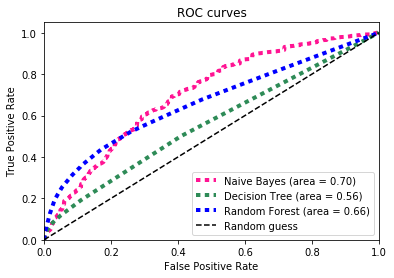

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# shuffle and split training and test sets in 4:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=4)

# initialize 3 classifiers
nb = MultinomialNB()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

models = [nb, dt, rf]

colors = cycle(['deeppink', 'seagreen', 'blue'])
model_names = ['Naive Bayes', 'Decision Tree', 'Random Forest']

plt.figure()

for model, color, model_name in zip(models, colors, model_names):
    
    # Learn to predict each class against the other
    classifier = OneVsRestClassifier(model)
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(10):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # plot ROC curve

#     plt.plot(fpr["micro"], tpr["micro"],
#              label= model_name + ' (area = {0:0.2f})'
#                    ''.format(roc_auc["micro"]),
#              color=color, linestyle=':', linewidth=4)
    
    plt.plot(fpr["macro"], tpr["macro"],
             label= model_name + ' (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color=color, linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right")
plt.show()
